In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

cwd = os.getcwd()

START_TRADE = 9.5 * 60 * 60
END_TRADE = 16 * 60 *60

In [3]:
# Loading the data
def load_lobster(filename, start_time, end_time, time_format = False):
    df_temp = pd.read_csv(filename, names = ['time','type','order_id','size','price','trade_direction'])
    df_temp["row_index"] = df_temp.index.values

    # Filter the trades of interest
    df_fitered = df_temp[df_temp["time"] >= start_time]
    df_filtered = df_temp[df_temp["time"] <= end_time]

    # Reformat time index of rows and add a Time column
    df_filtered = df_filtered.set_index(pd.to_datetime(df_filtered.time, unit='s'))

    return df_filtered

In [4]:
# Load the data, time_format = True to convert the time to a datetime object
amzn = load_lobster("data/AMZN_sample.csv", start_time = START_TRADE, end_time = END_TRADE, time_format = True)
msft = load_lobster("data/MSFT_sample.csv", start_time = START_TRADE, end_time = END_TRADE, time_format = True)

In [5]:
amzn.head()

,time,type,order_id,size,price,trade_direction,row_index
time,,,,,,,
1970-01-01 09:30:00.017459617,34200.017460,5,0,1,2238200,-1,0
1970-01-01 09:30:00.189607670,34200.189608,1,11885113,21,2238100,1,1
1970-01-01 09:30:00.189607670,34200.189608,1,3911376,20,2239600,-1,2
1970-01-01 09:30:00.189607670,34200.189608,1,11534792,100,2237500,1,3
1970-01-01 09:30:00.189607670,34200.189608,1,1365373,13,2240000,-1,4


In [6]:
msft.head()

,time,type,order_id,size,price,trade_direction,row_index
time,,,,,,,
1970-01-01 09:30:00.013994120,34200.013994,3,16085616,100,310400,-1,0
1970-01-01 09:30:00.013994120,34200.013994,1,16116348,100,310500,-1,1
1970-01-01 09:30:00.015247805,34200.015248,1,16116658,100,310400,-1,2
1970-01-01 09:30:00.015442111,34200.015442,1,16116704,100,310500,-1,3
1970-01-01 09:30:00.015789147,34200.015789,1,16116752,100,310600,-1,4


In [7]:
# Check data shape
print(msft.shape) # Return the number of rows and columns, excluding the index
print(amzn.shape)

# Check index precision
print(msft.index.dtype)
print(amzn.index.dtype)

# Or alternatively
print(msft.index[0]) # Just to observe the precision of the index, as we see here is 10^-9 seconds, which is nanoseconds

(668765, 7)
(269748, 7)
datetime64[ns]
datetime64[ns]
1970-01-01 09:30:00.013994120


In [8]:
# Sum of trade volume
msft.filter()

TypeError: Must pass either `items`, `like`, or `regex`

In [ ]:
# Create summary data
def summary(lobster_data):
    summary = lobster_data.groupby("type")["size"].agg(["count", "sum"])
    summary = summary / summary.sum()
    summary["description"] = summary.index.map({1:'New LO',2:'Cancel',3:'Deletion',4:'Execution visible',5:'Execution hidden'})
    return summary

In [ ]:
amzn_summary = summary(amzn)
msft_summary = summary(msft)

print(amzn_summary)
print(msft_summary)

         count       sum        description
type                                       
1     0.489175  0.498550             New LO
2     0.010814  0.013223             Cancel
3     0.457679  0.457200           Deletion
4     0.033268  0.023469  Execution visible
5     0.009064  0.007558   Execution hidden
         count       sum        description
type                                       
1     0.492798  0.503541             New LO
2     0.008377  0.006280             Cancel
3     0.448862  0.458995           Deletion
4     0.044557  0.028486  Execution visible
5     0.005407  0.002699   Execution hidden


In [ ]:
def check_for_halts(filtered_data):

    # Note: As the rows of the message and orderbook file correspond to each other, the time index of
    # the message file can also be used to 'cut' the orderbook file.

    # Check for trading halts
    # ----------------------------------------------------------
    tradingHaltIdx = filtered_data.index[(filtered_data.type == 7) & (filtered_data.price == -1) & (filtered_data.trade_direction == -1)]

    tradeQuoteIdx = filtered_data.index[(filtered_data.type == 7) & (filtered_data.price == 0)& (filtered_data.trade_direction == -1)]

    tradeResumeIdx = filtered_data.index[(filtered_data.type == 7) & (filtered_data.price == 1)& (filtered_data.trade_direction == -1)]

    if (len(tradingHaltIdx) == 0 | len(tradeQuoteIdx) == 0  | len(tradeResumeIdx) == 0):
        print("No trading halts detected.")

    if(len(tradingHaltIdx) != 0):
        print("Data contains trading halt! at time stamp(s): "); print(list(tradingHaltIdx))

    if(len(tradeQuoteIdx) != 0):
        print(" Data contains quoting message! at time stamp(s)"); print(list(tradeQuoteIdx)) 

    if(len(tradeResumeIdx) != 0):
        print(" Data resumes trading! at time stamp(s) "); print(list(tradeResumeIdx))

In [ ]:
check_for_halts(amzn)
check_for_halts(msft)

No trading halts detected.
No trading halts detected.


#### Hidden Order Analysis

In [ ]:
# Plot visible and invisible orders
def visible_invisible_plot(lobster_data, interval = 300):
    # Set index to a time index
    try:
        assert type(lobster_data.index) == pd.core.indexes.datetimes.DatetimeIndex # type: ignore
        
    except AssertionError:
        df_temp = lobster_data.set_index(pd.to_datetime(lobster_data.Time, unit = 's'))
    df_temp = pd.DataFrame(lobster_data)

    # Select only trade executions (type 4 and 5)
    df_temp = df_temp[df_temp.type.isin([4,5])]

    # Create columns for visible and invisible trades
    df_temp["visible"] = df_temp.type == 4
    df_temp["invisible"] = -1 * (df_temp.type == 5) # Flip hidden trades on x axis
    df_temp["visible size"] = df_temp["size"] * df_temp["visible"]
    df_temp["invisible size"] = df_temp["size"] * df_temp["invisible"]

    # IMPORTANT: Spliting sample data into 5 minute intervals, <label> = right means that the label of the interval is the right end of the interval
    df_resampled = df_temp.resample(str(interval) + "S", label = "right").sum() #.sum sums up all volumes in the interval

    # print(df_resampled.head())

    # Plotting
    fig, ax = plt.subplots(2, 1, sharex = True, figsize = (10,6))

    # Setting y axis to volume
    df_resampled[["visible", "invisible"]].plot(ax = ax[0], kind = "area", stacked = True, color = ('#5E81AC', '#88C0D0'))
    ax[0].set_ylabel("Number of Orders Executed")

    df_resampled[["visible size", "invisible size"]].plot(ax = ax[1], kind = "area", stacked = True, color = ('#5E81AC', '#88C0D0'))
    ax[1].set_ylabel("Volume of Orders Executed")

    # Setting title
    ax[0].set_title(f"Visible and Invisible Orders over {interval} sec rolling window")

    # Setting grid
    ax[0].set_axisbelow(True)
    ax[1].set_axisbelow(True)
    ax[0].grid(True, which = 'both', color = "#D8DEE9", linestyle = '-')
    ax[1].grid(True, which = 'both', color = "#D8DEE9", linestyle = '-')

    return df_resampled

C:\Users\Jason\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\events.py:93: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
C:\Users\Jason\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


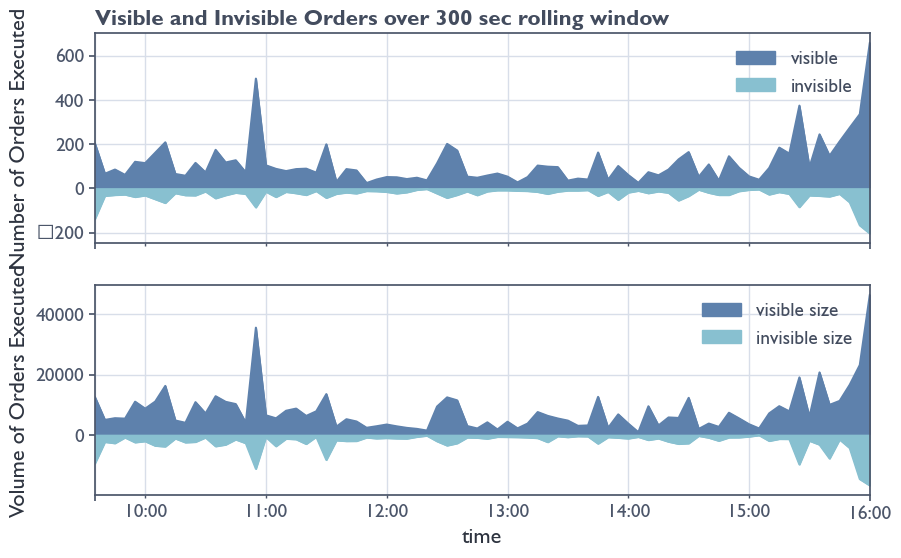

In [ ]:
amzn_resampled = visible_invisible_plot(amzn, interval = 300)

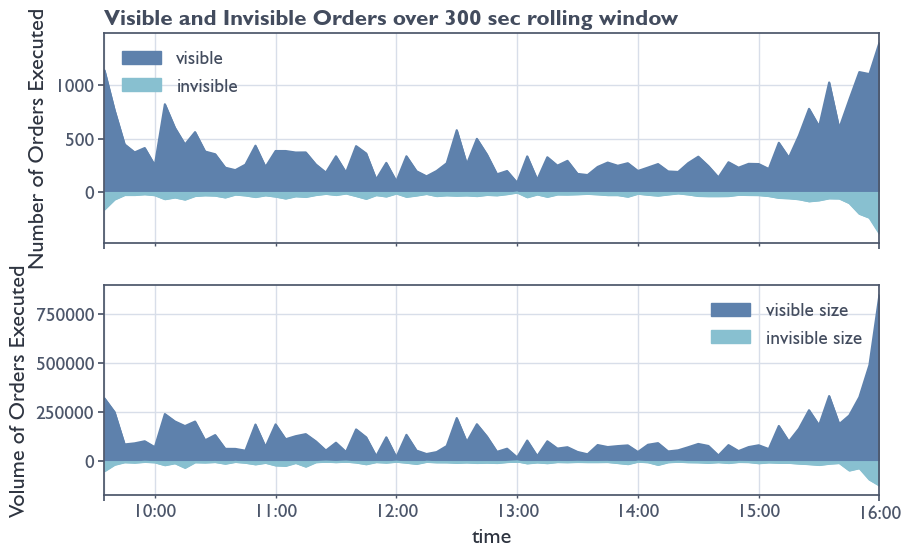

In [ ]:
msft_resampled = visible_invisible_plot(msft, interval = 300)

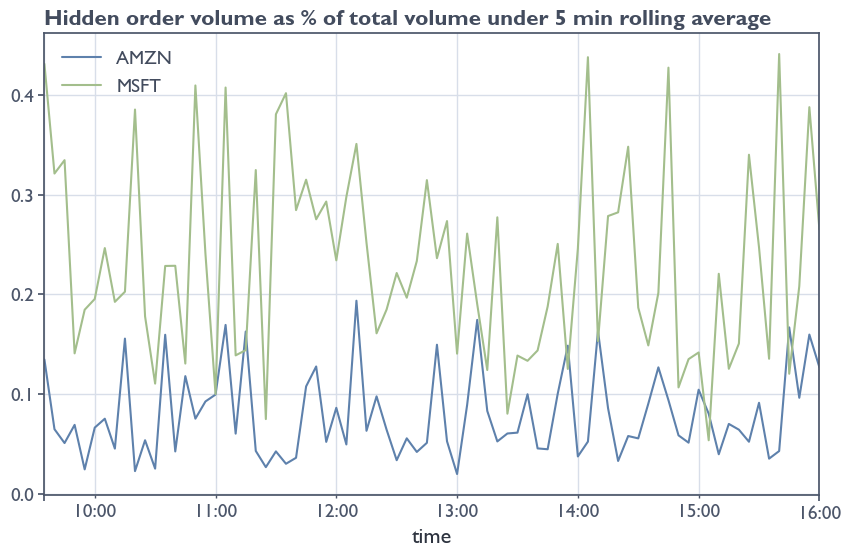

In [ ]:
# Percentage of invisible size out of total size
fig, ax = plt.subplots(1, 1, sharex = True, figsize = (10,6))
ax.set_axisbelow(True)
ax = (-1 * msft_resampled["invisible size"] / msft_resampled["size"]).plot(figsize = (10,6), kind = "line", color = "#5E81AC")
ax = (-1 * amzn_resampled["invisible size"] / amzn_resampled["size"]).plot(figsize = (10,6), kind = "line", color = "#A3BE8C")
ax.grid(True, which = 'both', color = "#D8DEE9", linestyle = '-')
ax.legend(labels = ["AMZN", "MSFT"])
ax.set_title(r"Hidden order volume as % of total volume under 5 min rolling average")
plt.show()

#### Emperical Properties of the LOB

In [ ]:
def loadOrderBook(theMessageBook, ticker='AMZN'):
    #_____________________________________________________________________________
    #
    # Load Order Book File
    # This is going to output a dictionary of four dataframes - asks/bids prices/sizes
    #It will be indexed by the time index formed from the messagebook df
    #_____________________________________________________________________________
    nlevels = 10 #change number of levels

    # Load data
    theOrderBookFileName = ticker + "_2012-06-21_34200000_57600000_orderbook_10.csv"
    theOrderBookFileName=os.path.join(cwd,"data",theOrderBookFileName)
    print(theOrderBookFileName)

    col = ['Ask Price ','Ask Size ','Bid Price ','Bid Size ']
    theNames = [str(col_name)+str(level_no) for level_no in range(1,nlevels+1) for col_name in col ]

    theOrderBook = pd.read_csv(theOrderBookFileName, names = theNames)
        
    #timeIndex = theMessageBook.index[(theMessageBook.Time >= startTrad) & (theMessageBook.Time <= endTrad)]
    #theOrderBookFiltered = theOrderBook[theOrderBook.index == timeIndex]

    # Filter through time for orderbook, keep data time same as message book
    theOrderBookFiltered = theOrderBook.iloc[theMessageBook.row_index]
    
    #theOrderBookFiltered=theOrderBookFiltered.set_index(pd.to_datetime(theMessageBook.Time,unit='s'))
    theOrderBookFiltered = theOrderBookFiltered.set_index(theMessageBook.index)
    
    # Convert prices into dollars
    #    Note: LOBSTER stores prices in dollar price times 10000

    col = ['Ask Price ','Ask Size ','Bid Price ','Bid Size ']

    #separate the four types of column into a dictionary with key=column type
    data_col_dic = {c.strip():[c+str(level_no) for level_no in range(1,nlevels+1)] for c in col}

    #separate data into four aligned dataframes of the four different types of data with key=data type
    data_dic = {c:theOrderBookFiltered[cols] for c,cols in data_col_dic.items()}
      
    return data_dic

time
1970-01-01 09:30:00.017459617         0
1970-01-01 09:30:00.189607670         1
1970-01-01 09:30:00.189607670         2
1970-01-01 09:30:00.189607670         3
1970-01-01 09:30:00.189607670         4
                                  ...  
1970-01-01 15:59:59.872741285    269743
1970-01-01 15:59:59.903989046    269744
1970-01-01 15:59:59.955241980    269745
1970-01-01 15:59:59.958244616    269746
1970-01-01 15:59:59.959359650    269747
Name: row_index, Length: 269748, dtype: int64

In [ ]:
amzn.index

DatetimeIndex(['1970-01-01 09:30:00.017459617',
               '1970-01-01 09:30:00.189607670',
               '1970-01-01 09:30:00.189607670',
               '1970-01-01 09:30:00.189607670',
               '1970-01-01 09:30:00.189607670',
               '1970-01-01 09:30:00.189607670',
               '1970-01-01 09:30:00.189607670',
               '1970-01-01 09:30:00.189607670',
               '1970-01-01 09:30:00.189607670',
               '1970-01-01 09:30:00.189607670',
               ...
               '1970-01-01 15:59:59.545699342',
               '1970-01-01 15:59:59.545827862',
               '1970-01-01 15:59:59.545827862',
               '1970-01-01 15:59:59.546932875',
               '1970-01-01 15:59:59.548598316',
               '1970-01-01 15:59:59.872741285',
               '1970-01-01 15:59:59.903989046',
               '1970-01-01 15:59:59.955241980',
               '1970-01-01 15:59:59.958244616',
               '1970-01-01 15:59:59.959359650'],
              dtype=